In [1]:
import sys
sys.executable

'C:\\Users\\SEAN\\anaconda3\\envs\\Carbon_Cloud\\python.exe'

In [2]:
#Importing required libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
#Creating a dataframe
transport_df = pd.read_csv("C:\\Users\\SEAN\\Desktop\\Project\\Datasets\\CO2_Emissions_Canada.csv")
transport_df.head(50)

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
5,ACURA,RLX,MID-SIZE,3.5,6,AS6,Z,11.9,7.7,10.0,28,230
6,ACURA,TL,MID-SIZE,3.5,6,AS6,Z,11.8,8.1,10.1,28,232
7,ACURA,TL AWD,MID-SIZE,3.7,6,AS6,Z,12.8,9.0,11.1,25,255
8,ACURA,TL AWD,MID-SIZE,3.7,6,M6,Z,13.4,9.5,11.6,24,267
9,ACURA,TSX,COMPACT,2.4,4,AS5,Z,10.6,7.5,9.2,31,212


In [4]:
#Renaming column names
transport_df.rename(columns={'Make':'make', 'Model':'model', 'Vehicle Class':'vehicle_class', 'Engine Size(L)':'engine_size', 'Cylinders':'cylinders', 'Transmission':'transmission', 'Fuel Type':'fuel_type','CO2 Emissions(g/km)':'co2_emissions(g/km)'}, inplace=True)

#Information about the Dataframe
transport_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   make                              7385 non-null   object 
 1   model                             7385 non-null   object 
 2   vehicle_class                     7385 non-null   object 
 3   engine_size                       7385 non-null   float64
 4   cylinders                         7385 non-null   int64  
 5   transmission                      7385 non-null   object 
 6   fuel_type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  co2_emissions(g/km)               7385 non-null   int64  
dtypes: flo

In [5]:
# Qualitative variable visualization analysis using Countplot and Barplot.

In [6]:
# Excluding multiple columns in a dataframe

transport_df_qualitative = transport_df.drop(['engine_size','cylinders','Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'Fuel Consumption Comb (mpg)', 'co2_emissions(g/km)'], axis=1)
transport_df_qualitative.columns

Index(['make', 'model', 'vehicle_class', 'transmission', 'fuel_type'], dtype='object')

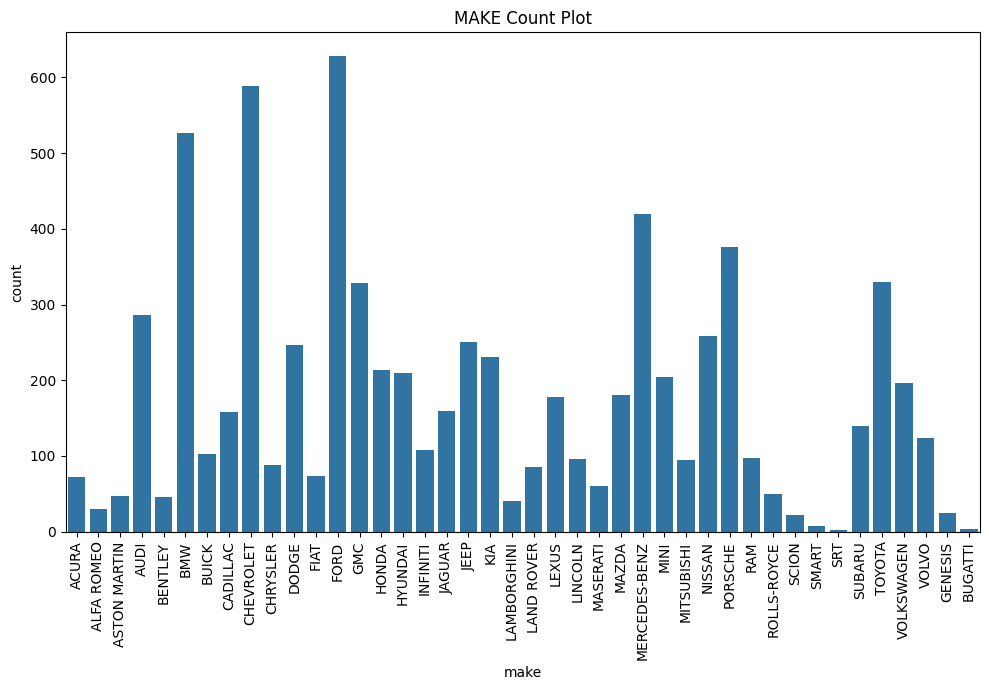

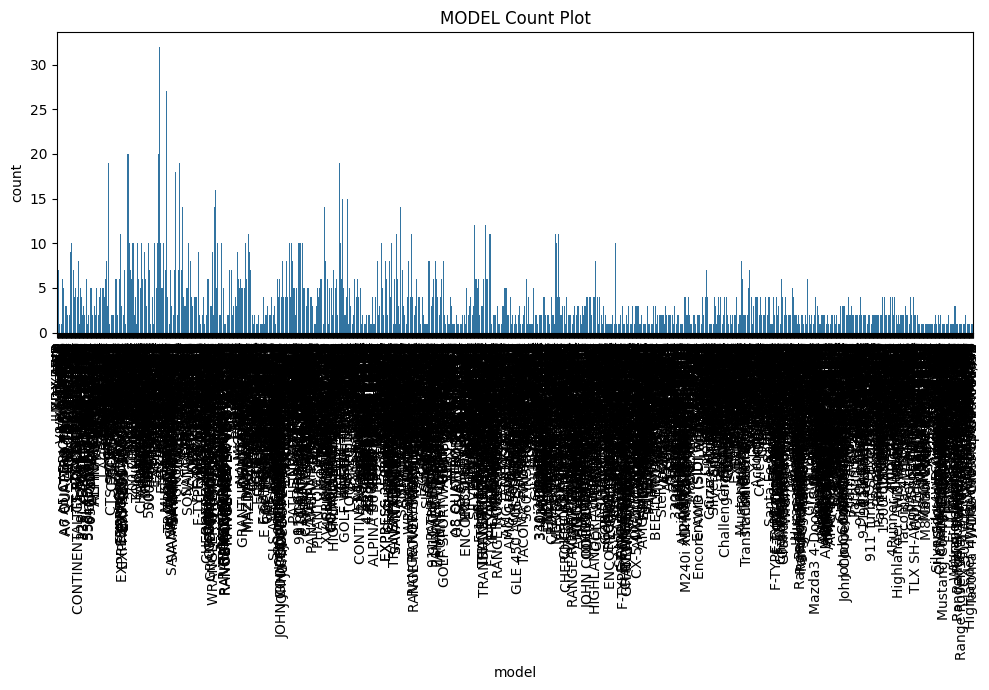

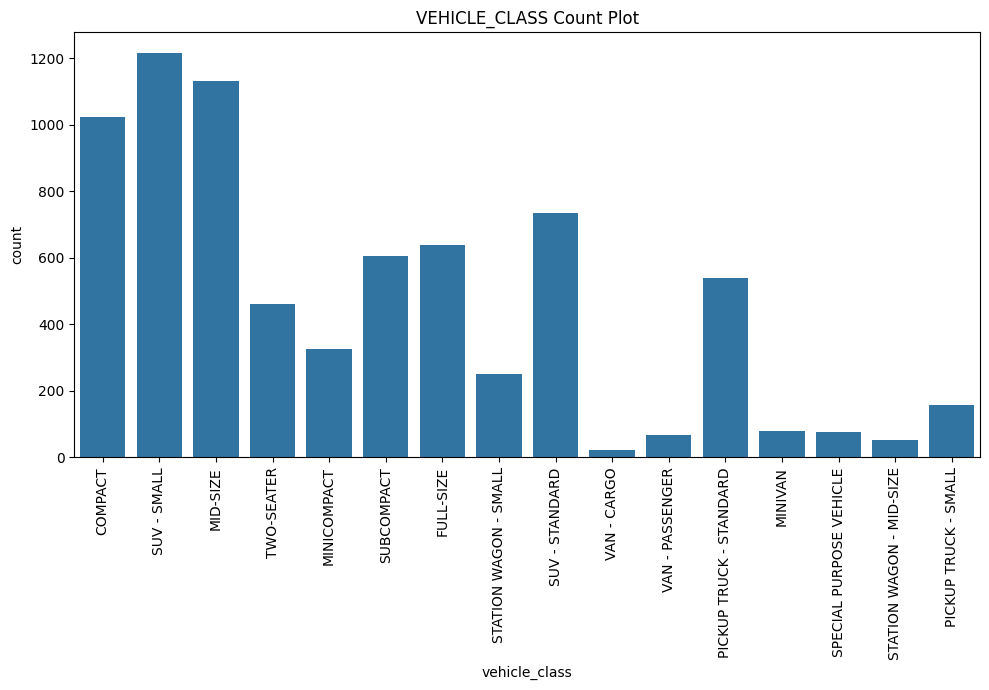

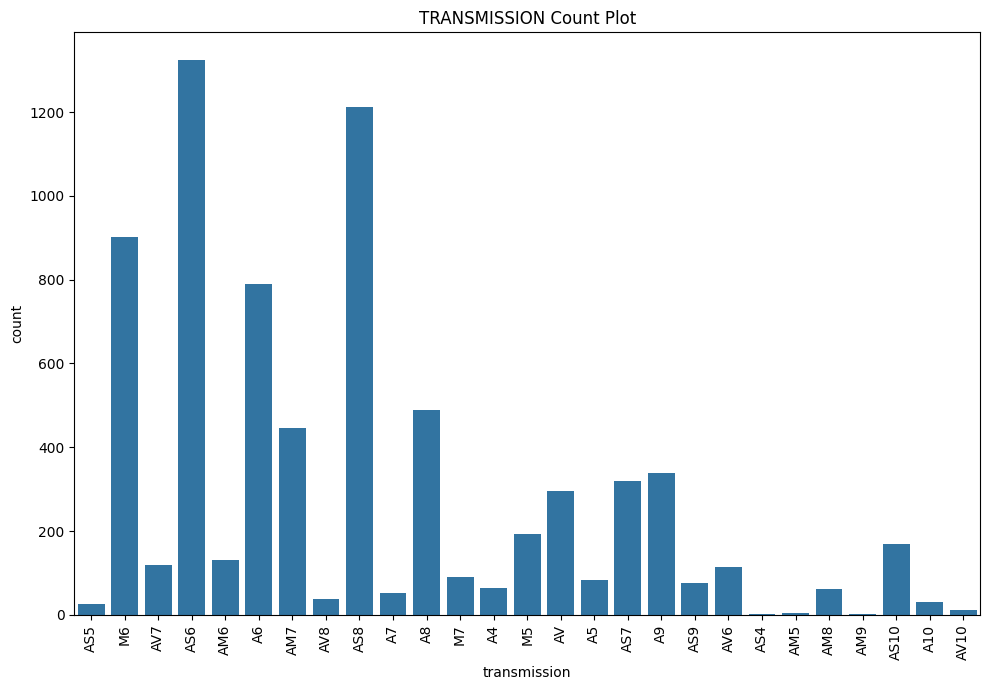

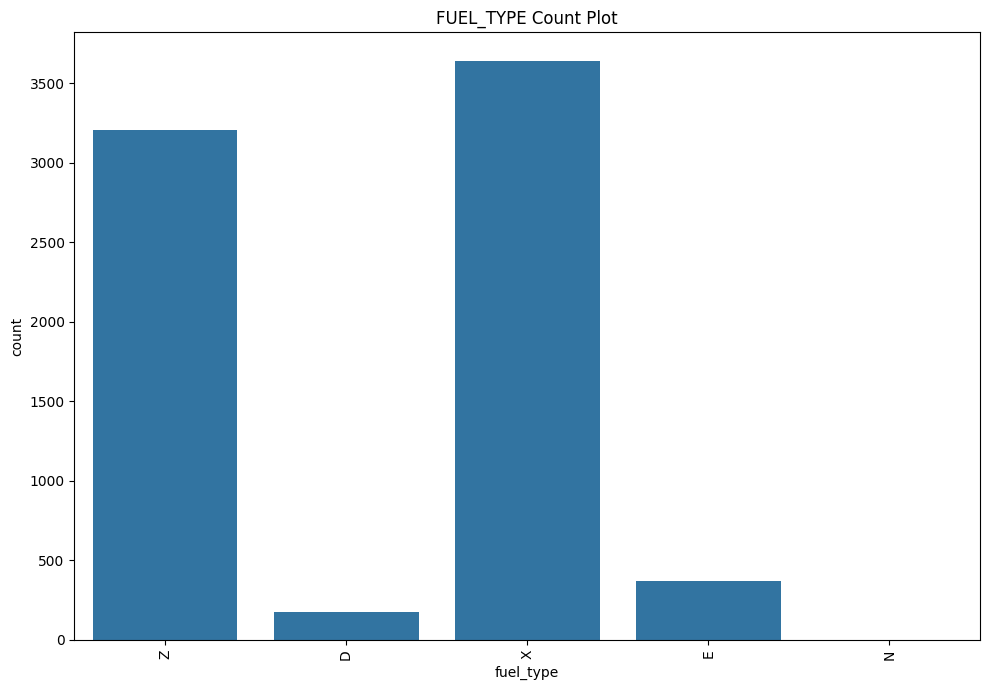

In [7]:
# Visualizing Using COUNT PLOT
for i in transport_df_qualitative.columns:
    plt.figure(figsize=(10,7))
    count_plt = sns.countplot(data=transport_df_qualitative, x=i)
    count_plt.set(title=i.upper() + " Count Plot")
    count_plt.tick_params(axis='x', rotation=90)
    plt.tight_layout()

In [20]:
transport_df['model'].nunique()

2053

In [9]:
#Test the Bar plot values

#new_df = car_price_df.query('Fuel_type == "Petrol"')
new_df = transport_df[transport_df['make'] == 'FORD']
new_df['co2_emissions(g/km)'].mean()

260.9888535031847

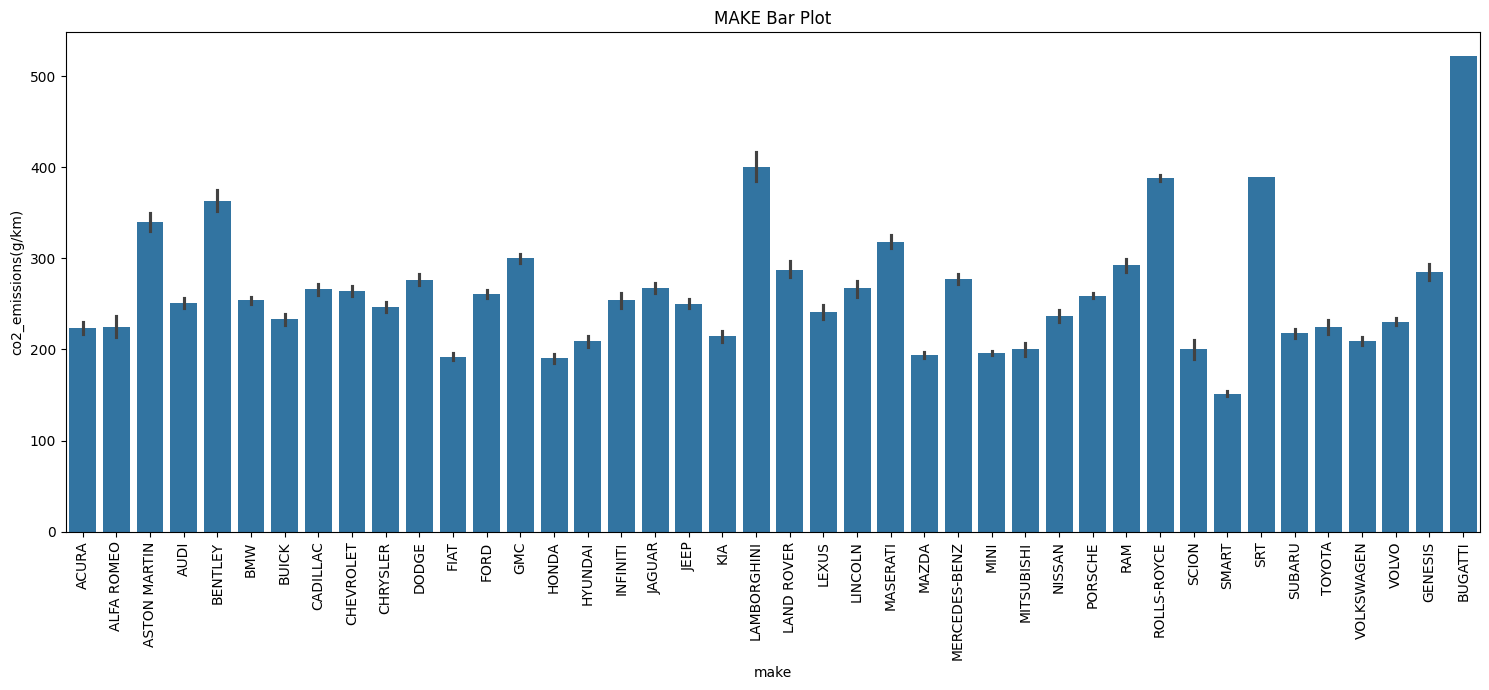

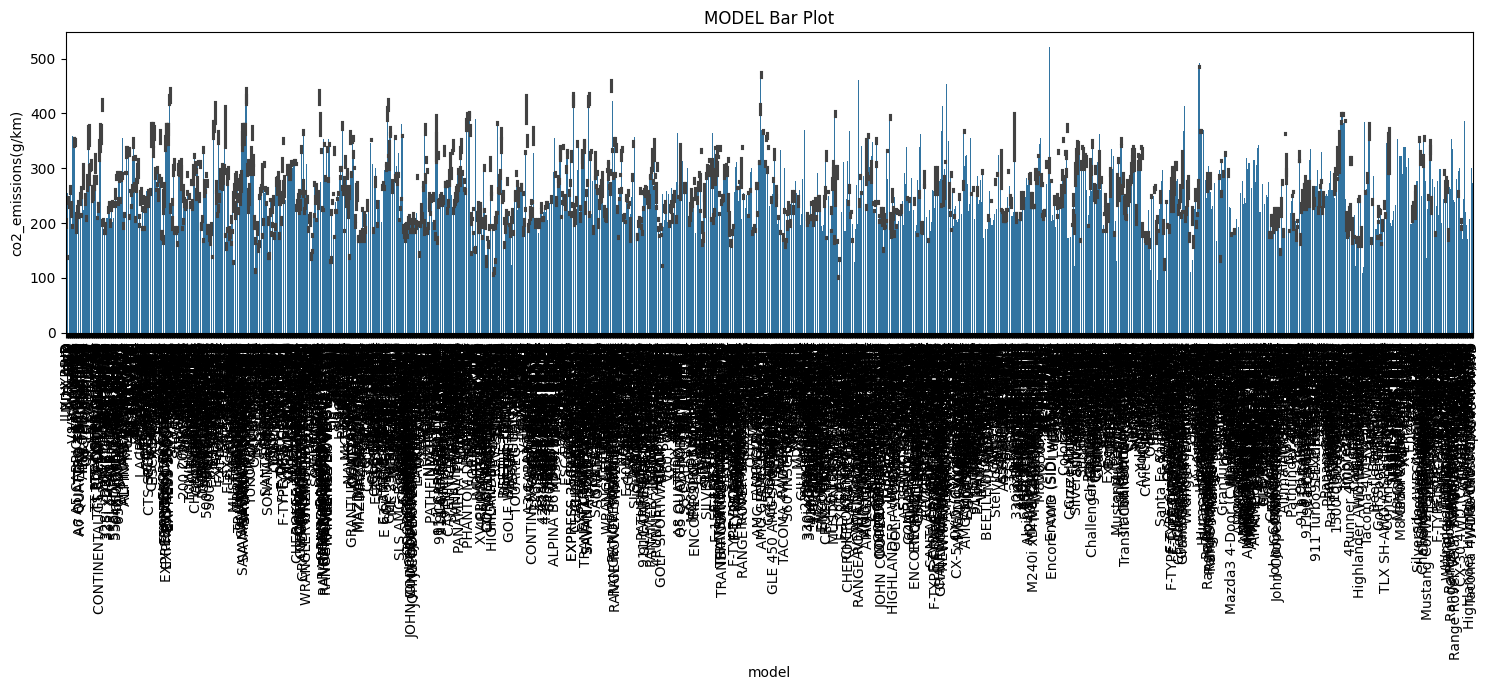

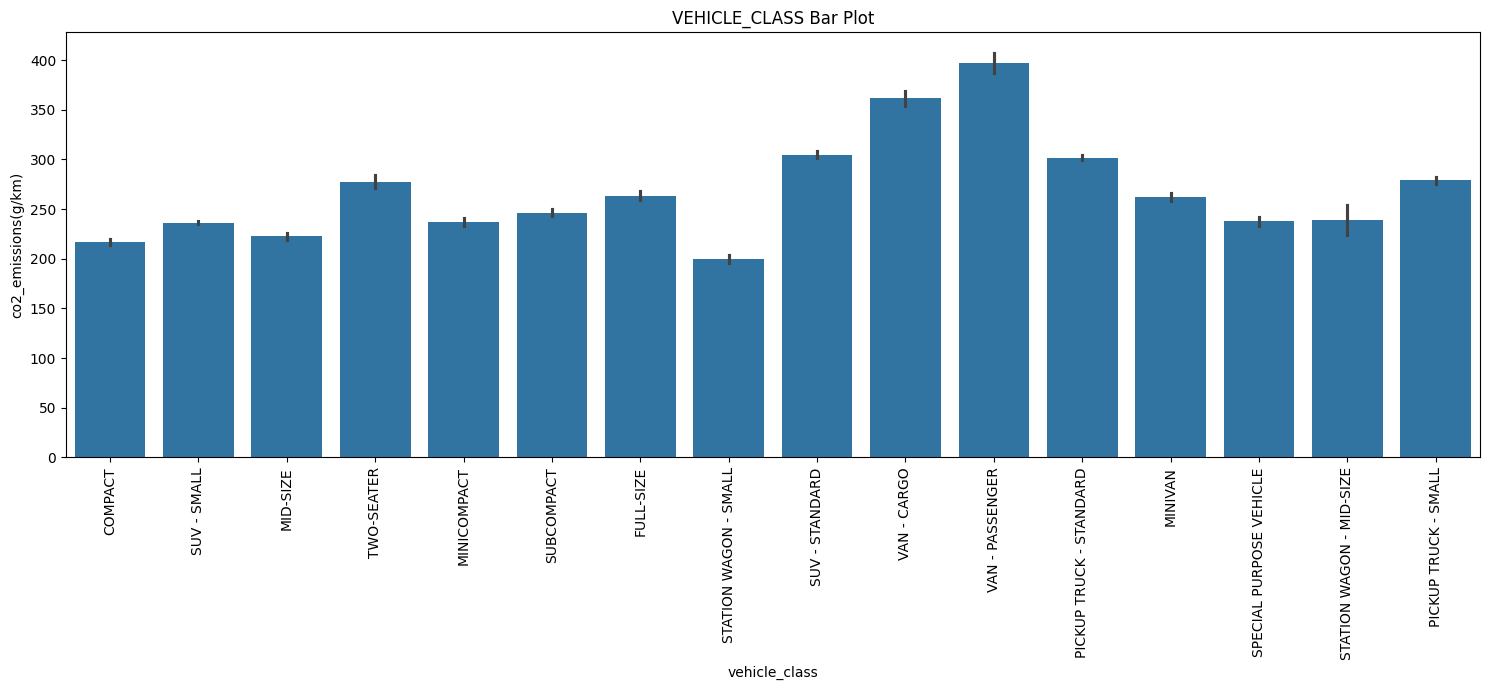

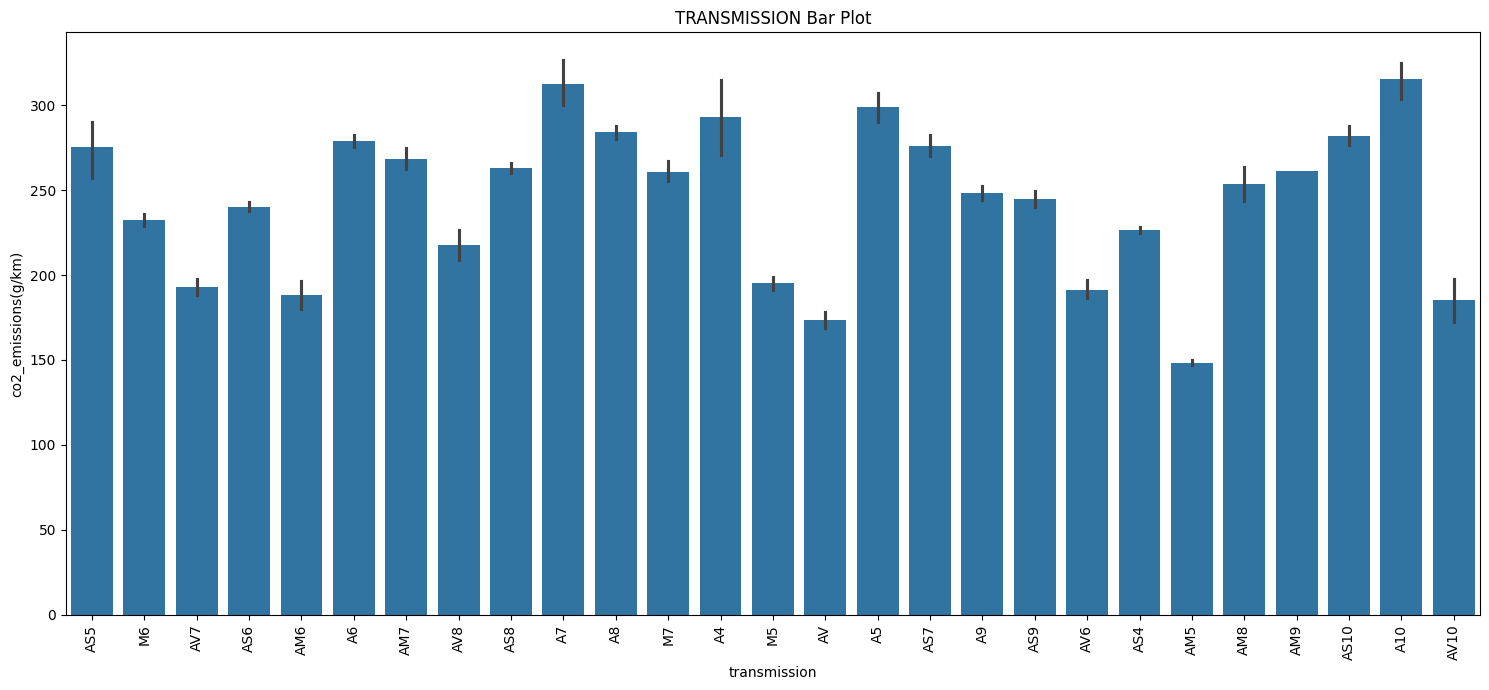

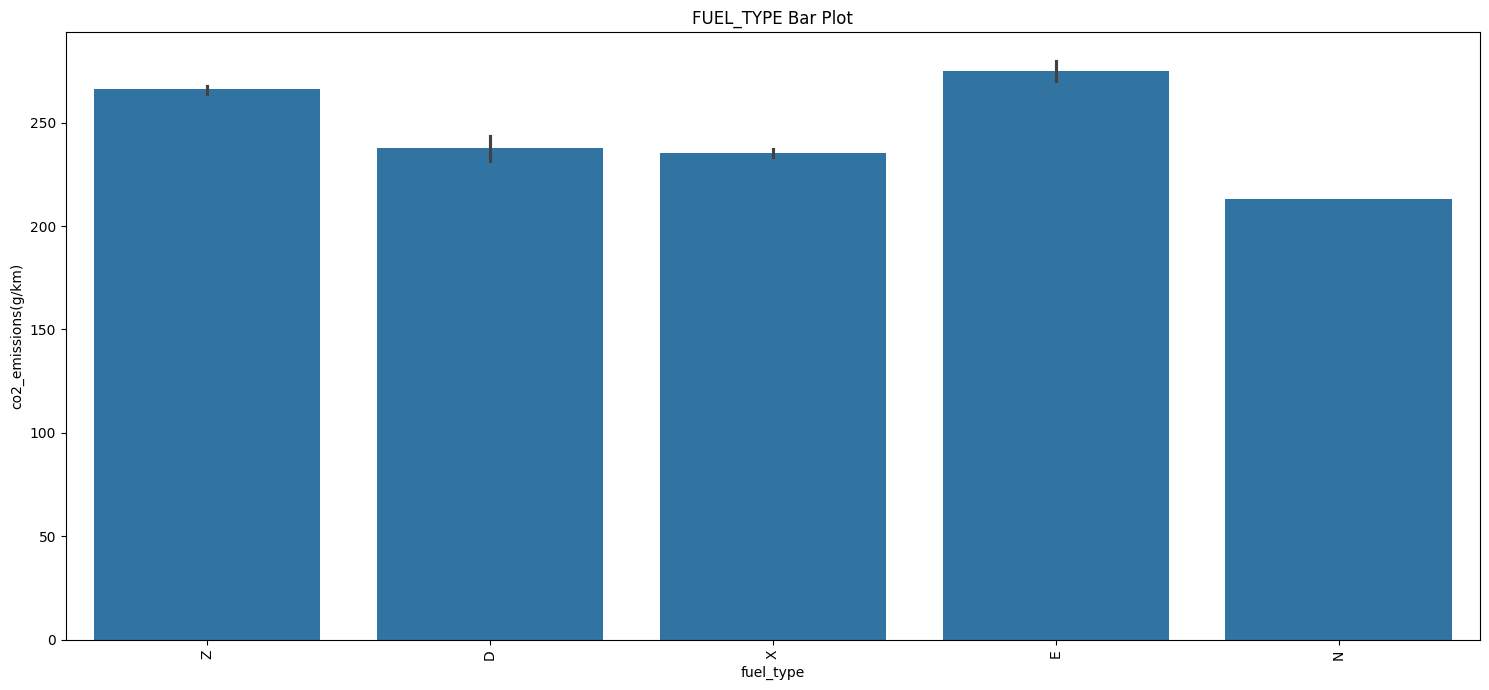

In [10]:
# Visualizing Using BAR PLOT (x -> categorical, y -> quantitative)
for i in transport_df_qualitative.columns:
    plt.figure(figsize=(15,7))
    bar_plot = sns.barplot(data=transport_df, x=i, y='co2_emissions(g/km)')
    bar_plot.set(title=i.upper() + " Bar Plot")
    bar_plot.tick_params(axis='x', rotation=90)
    plt.tight_layout()

In [11]:
# Quantitative variable visualization analysis using Hisplot (Histogram).

In [12]:
# Excluding multiple columns in a dataframe

transport_df_quantitative = transport_df.drop(['make','model', 'vehicle_class', 'transmission', 'fuel_type'], axis=1)
transport_df_quantitative.columns

Index(['engine_size', 'cylinders', 'Fuel Consumption City (L/100 km)',
       'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
       'Fuel Consumption Comb (mpg)', 'co2_emissions(g/km)'],
      dtype='object')

In [13]:
transport_df_quantitative.describe()

,engine_size,cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),co2_emissions(g/km)
count,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000
mean,3.160068,5.615030,12.556534,9.041706,10.975071,27.481652,250.584699
std,1.354170,1.828307,3.500274,2.224456,2.892506,7.231879,58.512679
min,0.900000,3.000000,4.200000,4.000000,4.100000,11.000000,96.000000
25%,2.000000,4.000000,10.100000,7.500000,8.900000,22.000000,208.000000
50%,3.000000,6.000000,12.100000,8.700000,10.600000,27.000000,246.000000
75%,3.700000,6.000000,14.600000,10.200000,12.600000,32.000000,288.000000
max,8.400000,16.000000,30.600000,20.600000,26.100000,69.000000,522.000000


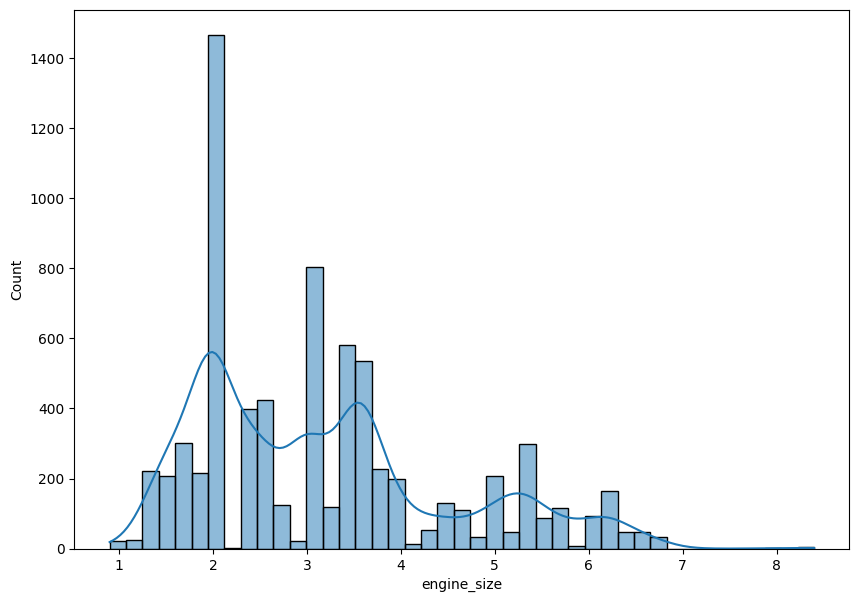

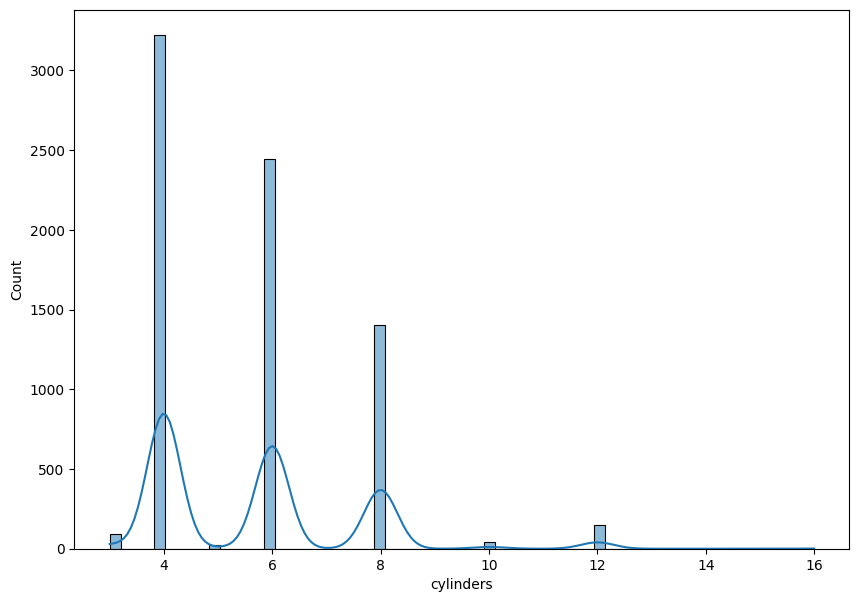

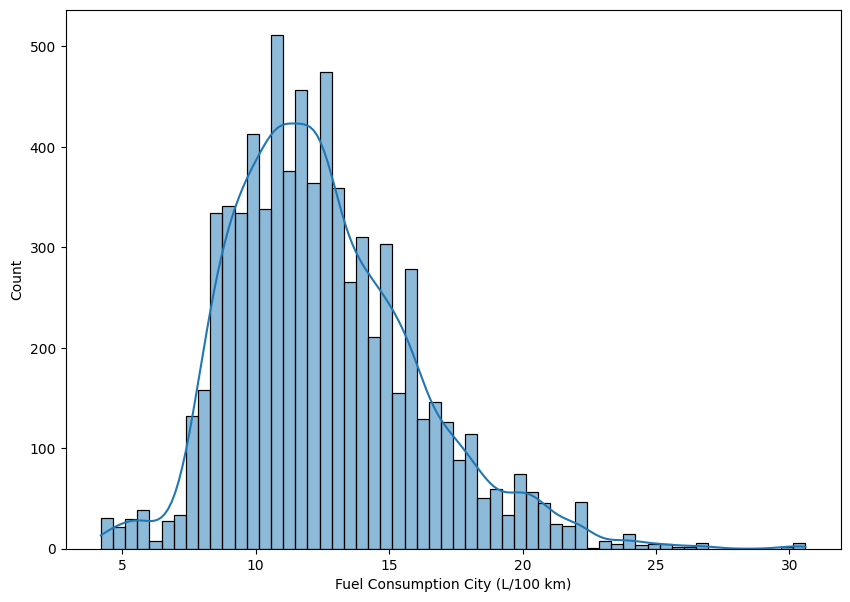

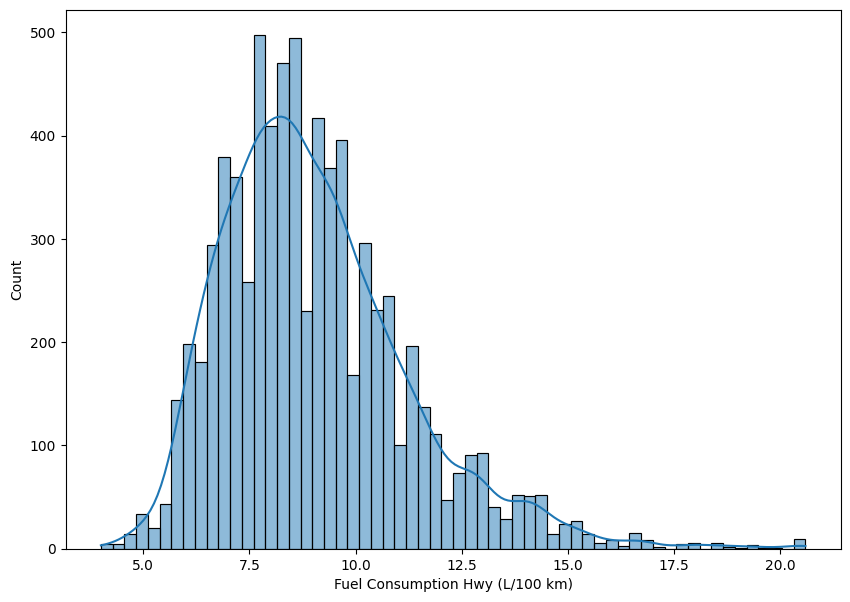

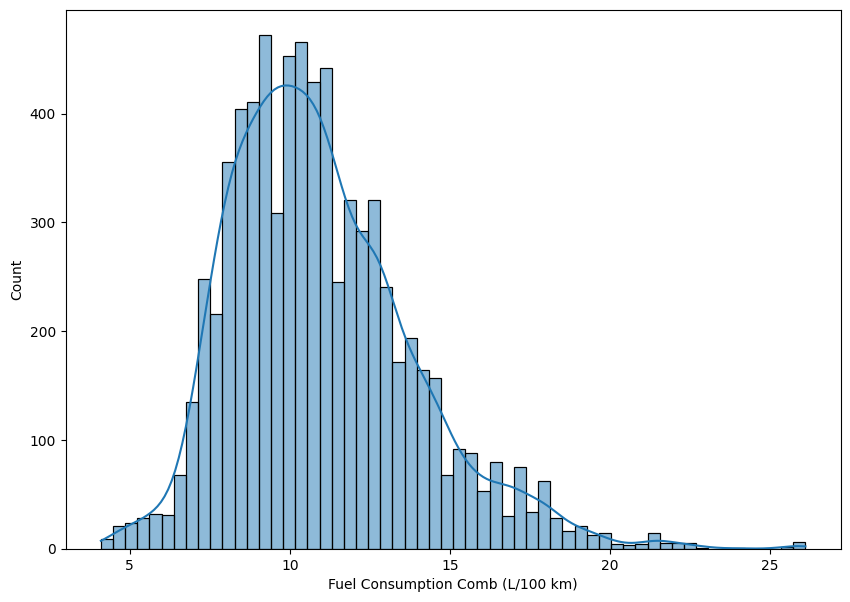

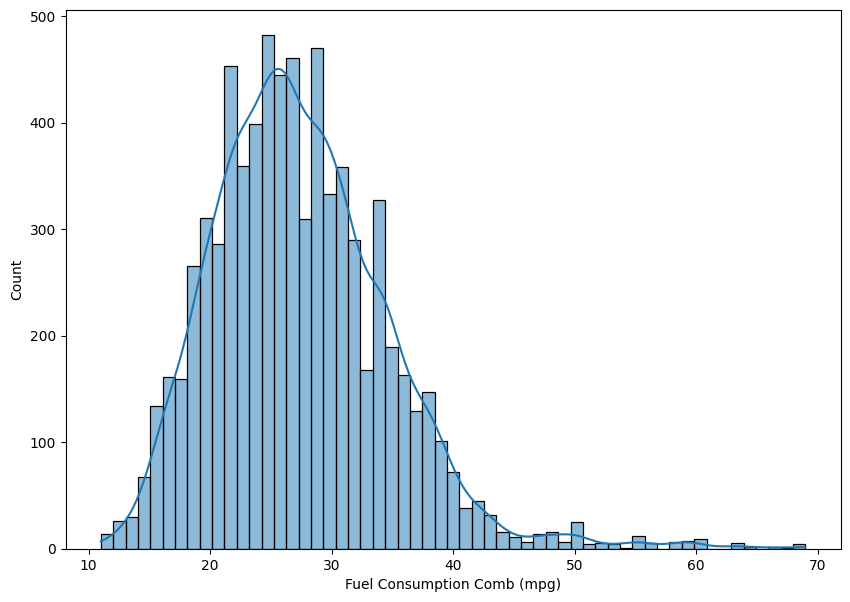

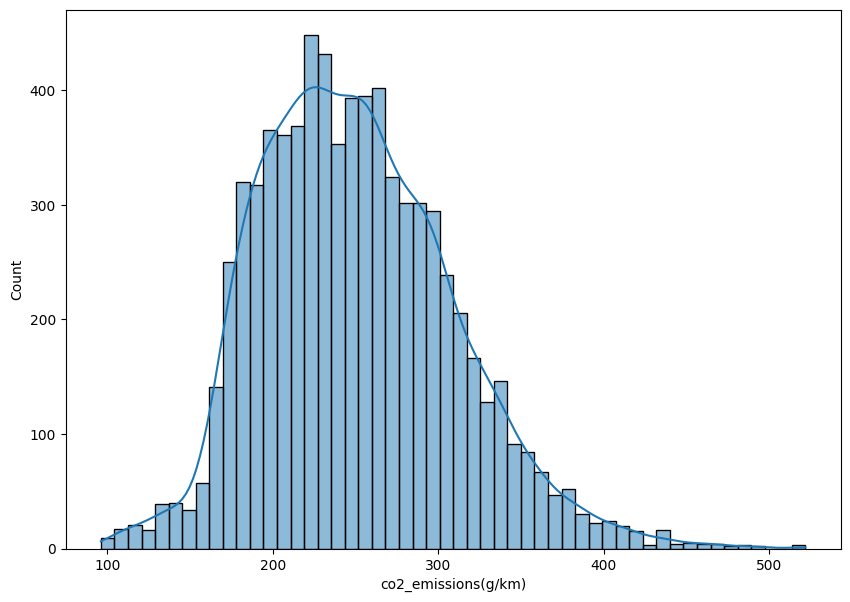

In [14]:
for i in transport_df_quantitative.columns:
    plt.figure(figsize=(10,7))
    sns.histplot(data=transport_df_quantitative, x=i, kde=True)

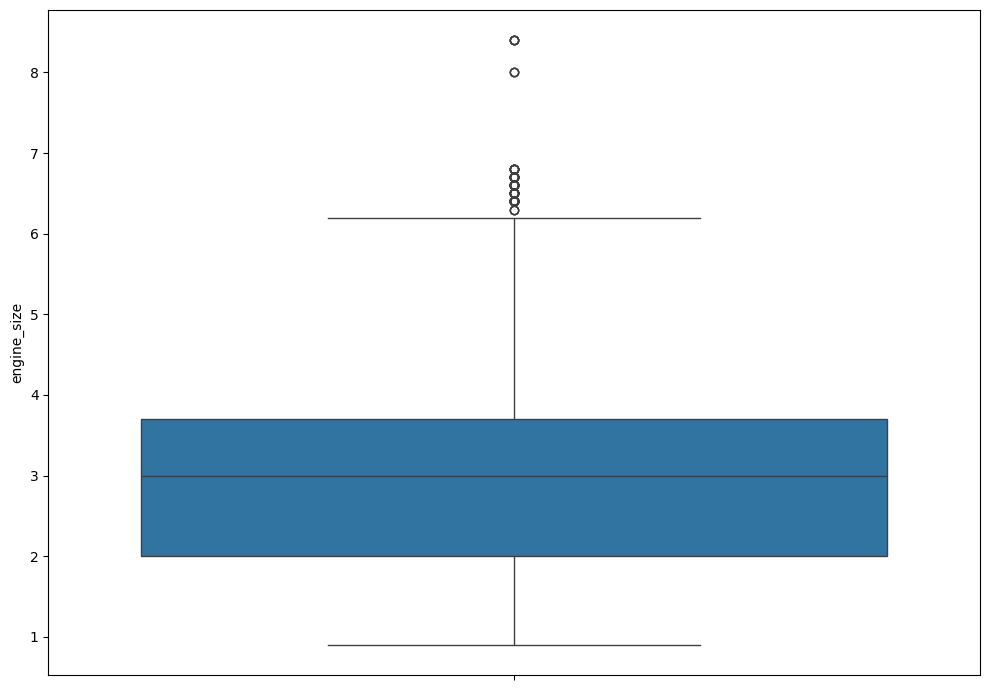

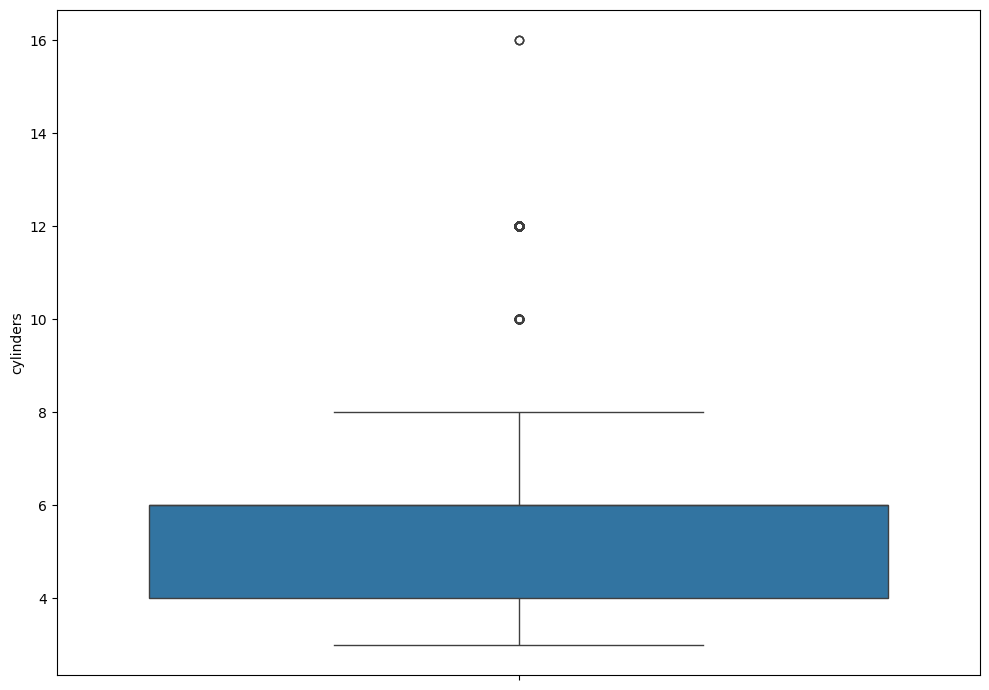

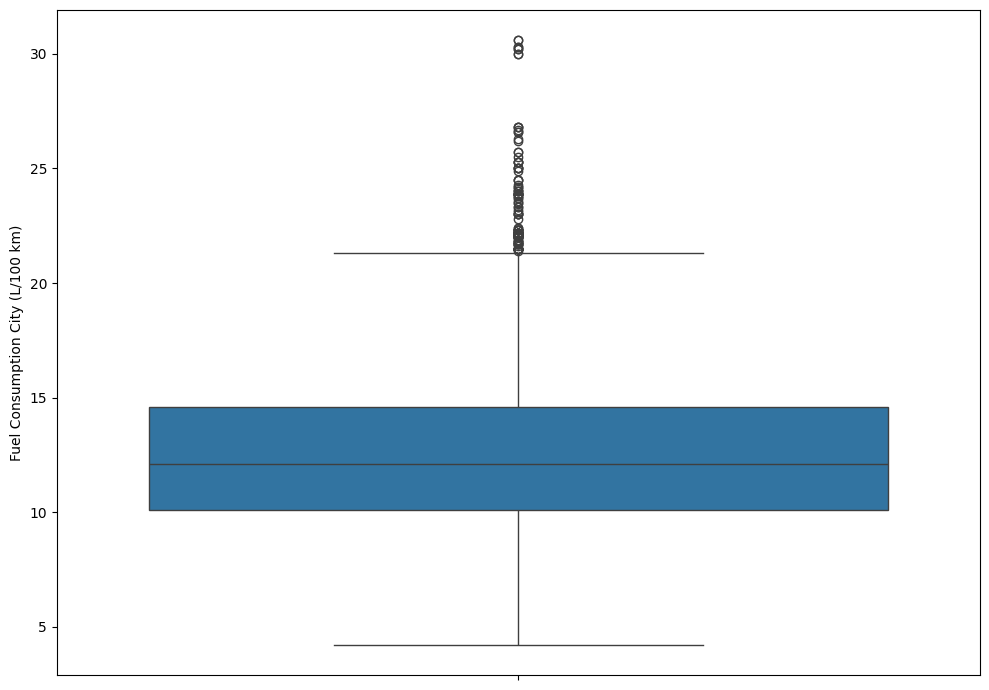

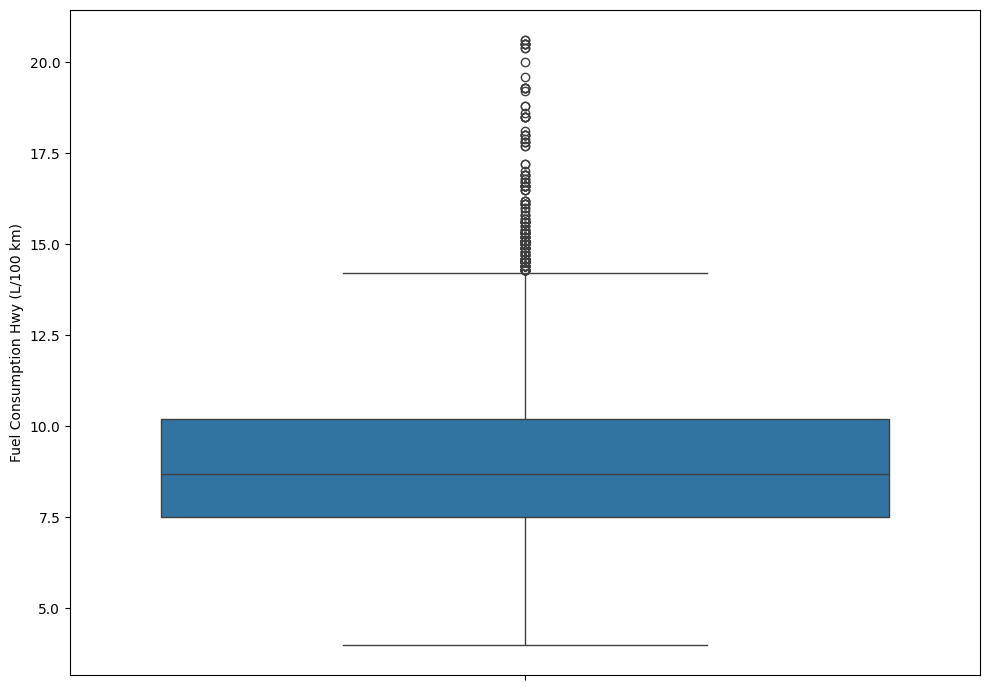

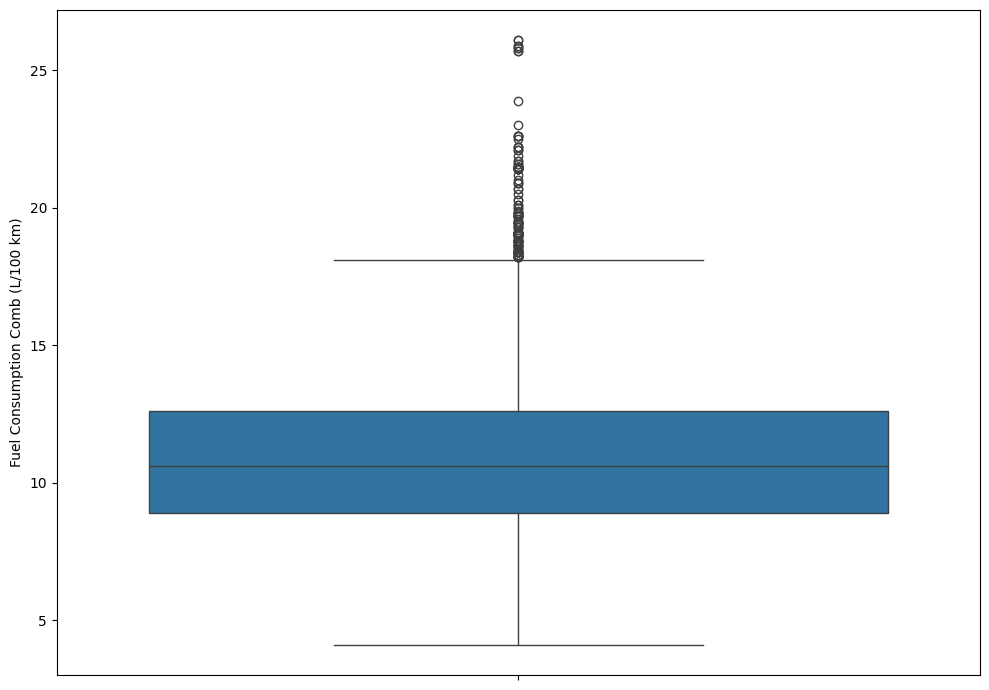

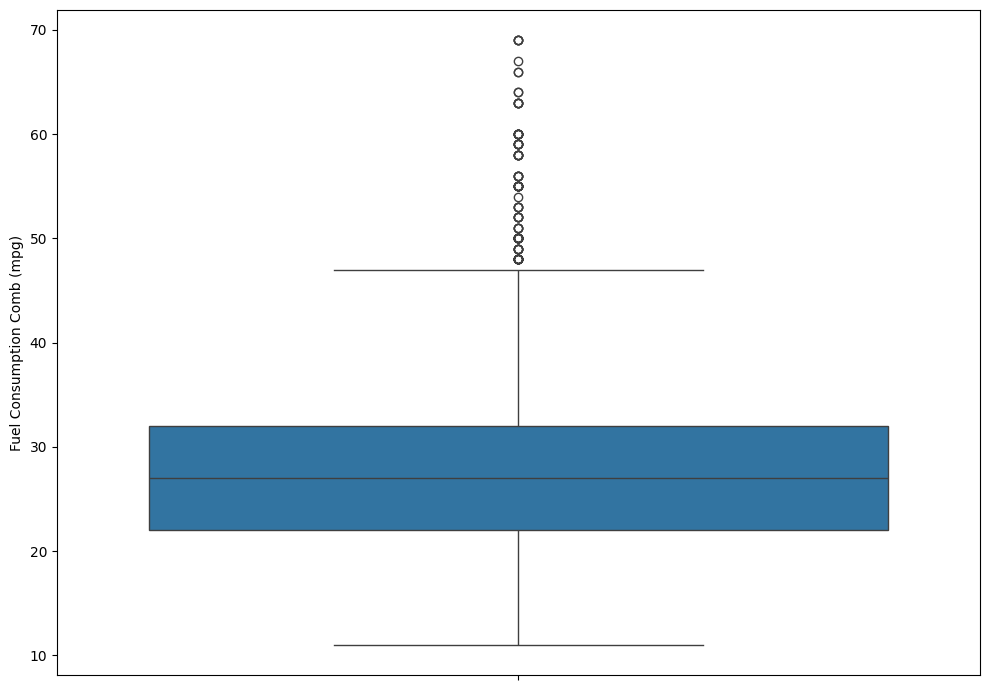

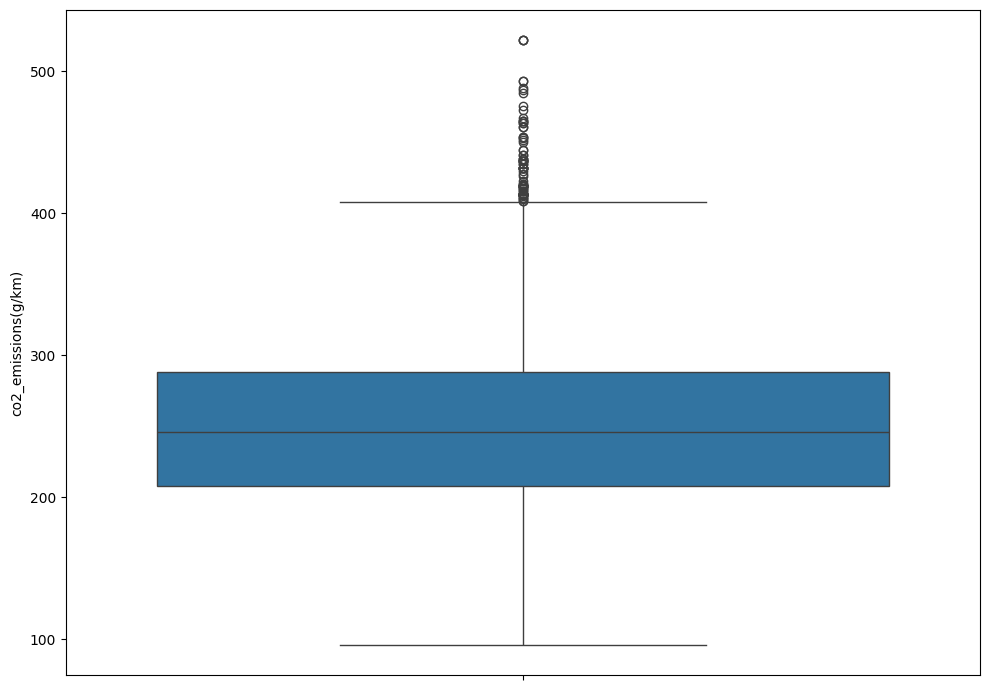

In [15]:
for i in transport_df_quantitative.columns:
    plt.figure(figsize=(10,7))
    sns.boxplot(data=transport_df_quantitative, y=i)
    plt.tight_layout()

In [27]:
#Finding correlation of the quatitative data with respect to the target_data[co2_emissions(g/km)]
correlation_matrix = transport_df_quantitative.corr()
target_correlation = correlation_matrix['co2_emissions(g/km)'].abs().sort_values(ascending=False)
target_correlation

co2_emissions(g/km)                 1.000000
Fuel Consumption City (L/100 km)    0.919592
Fuel Consumption Comb (L/100 km)    0.918052
Fuel Consumption Comb (mpg)         0.907426
Fuel Consumption Hwy (L/100 km)     0.883536
engine_size                         0.851145
cylinders                           0.832644
Name: co2_emissions(g/km), dtype: float64

<Axes: >

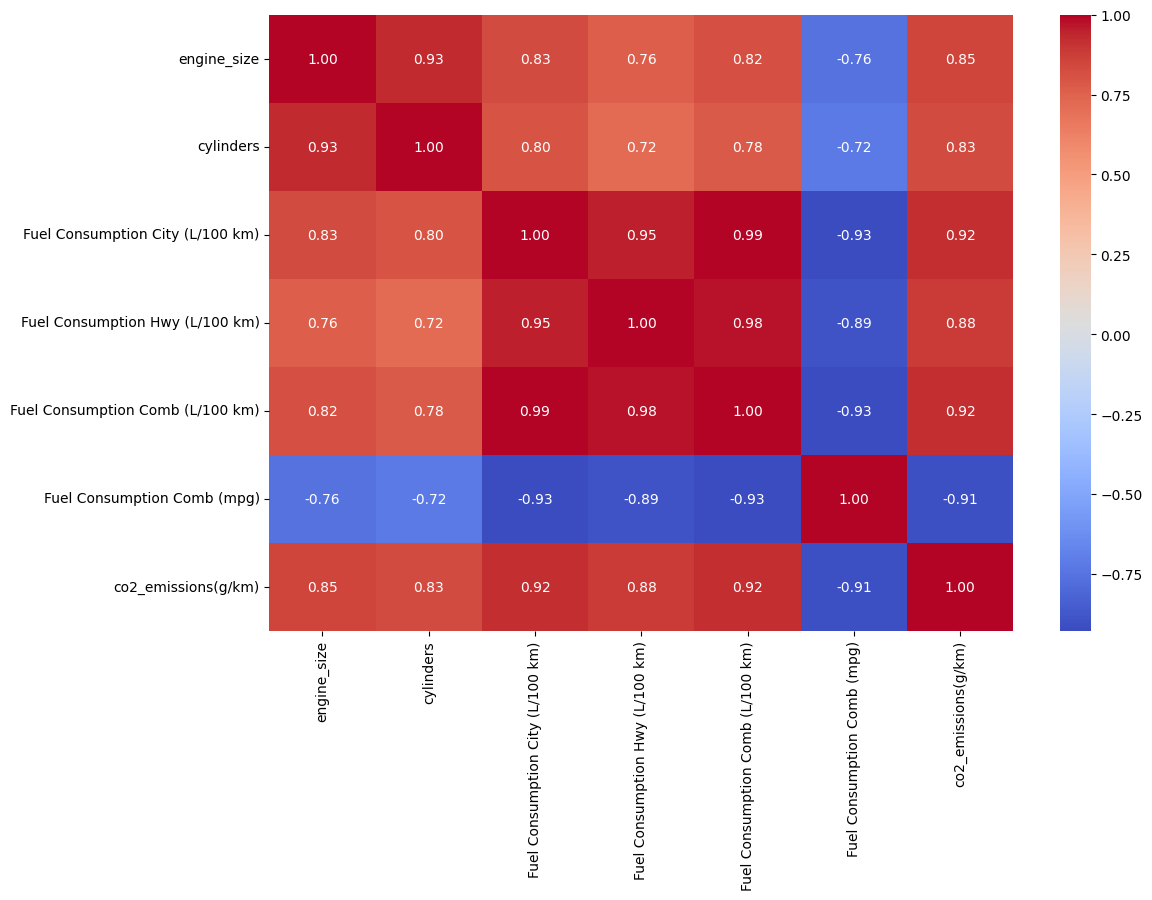

In [28]:
# Heatmap for correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [16]:
#Removing outliers

filtered_transport_df = transport_df.copy()

for i in transport_df_quantitative.columns:
    
    # Step 1: Calculate the Interquartile Range (IQR)
    Q1 = transport_df[i].quantile(0.25)
    Q3 = transport_df[i].quantile(0.75)
    IQR = Q3 - Q1
    
    # Step 2: Define the lower and upper bounds to identify outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Step 3: Filter out the outliers from the DataFrame
    filtered_transport_df = filtered_transport_df[(filtered_transport_df[i] >= lower_bound) & (filtered_transport_df[i] <= upper_bound)]

In [17]:
filtered_transport_df.describe()

,engine_size,cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),co2_emissions(g/km)
count,6826.000000,6826.000000,6826.000000,6826.000000,6826.000000,6826.000000,6826.000000
mean,3.014474,5.393349,12.179153,8.800308,10.658922,27.735423,245.680926
std,1.207377,1.509086,2.799971,1.802917,2.317081,5.992403,49.728477
min,0.900000,3.000000,5.600000,4.500000,6.000000,16.000000,128.000000
25%,2.000000,4.000000,10.000000,7.500000,8.900000,23.000000,207.000000
50%,3.000000,6.000000,11.900000,8.600000,10.400000,27.000000,242.000000
75%,3.600000,6.000000,14.100000,9.900000,12.200000,32.000000,280.000000
max,6.200000,8.000000,21.300000,14.200000,18.100000,47.000000,407.000000


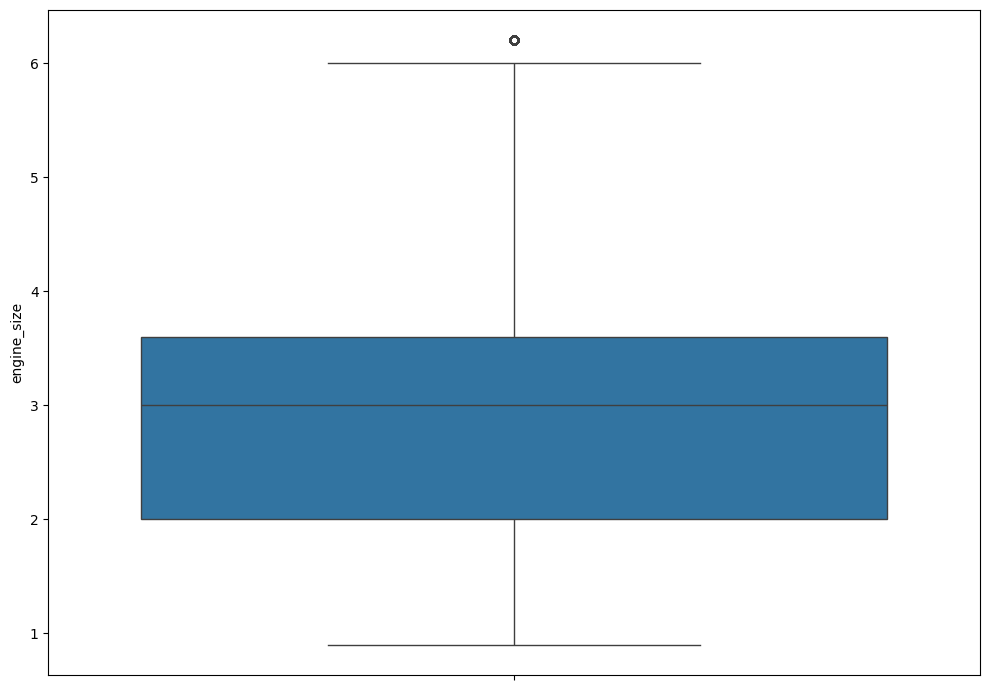

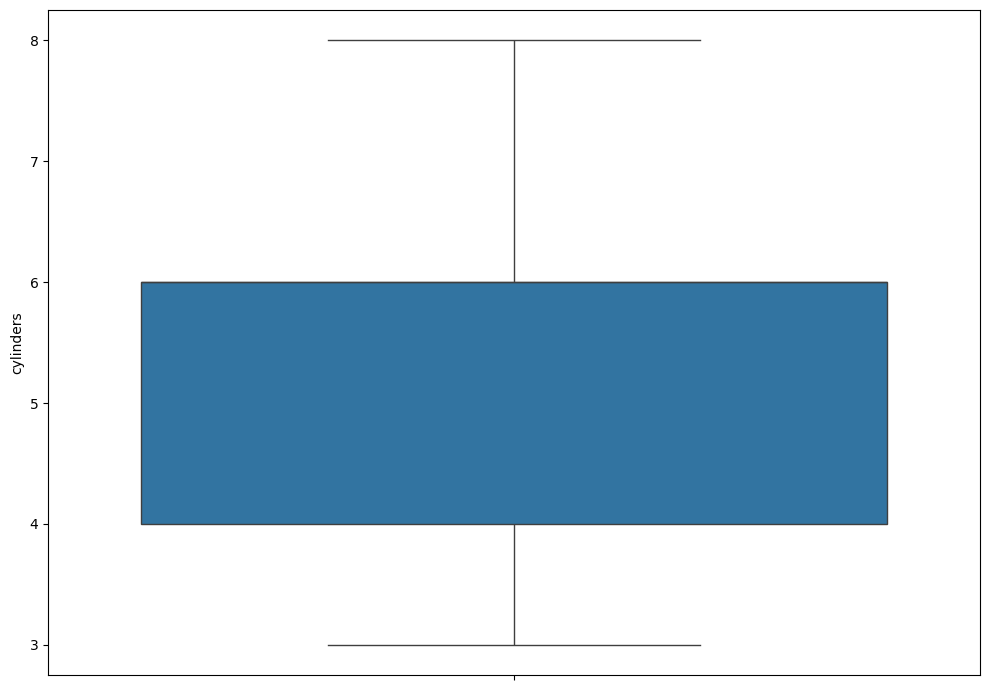

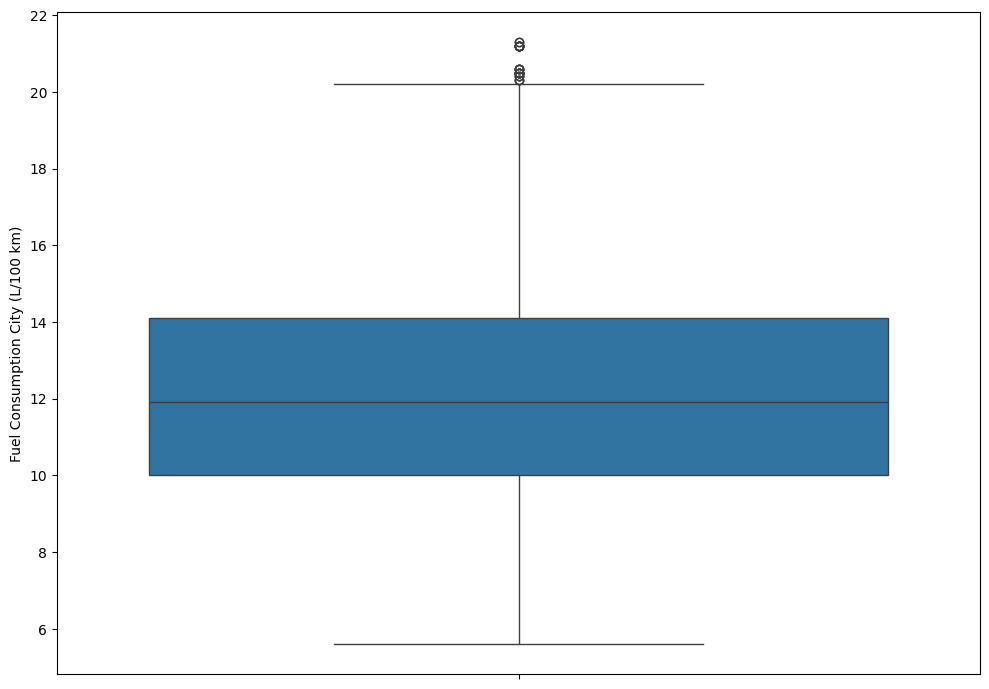

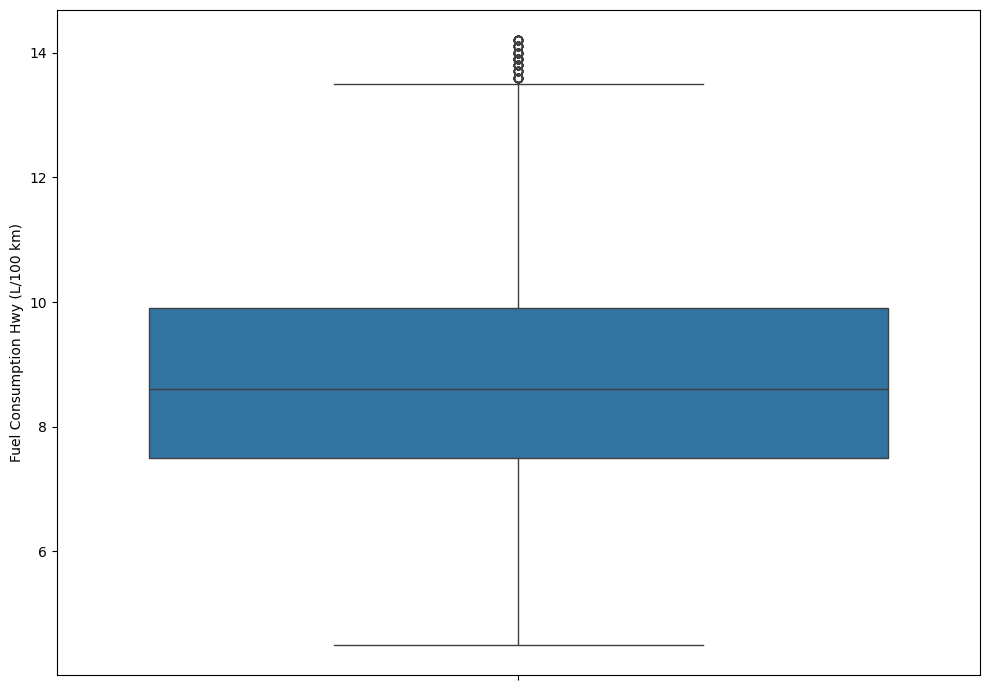

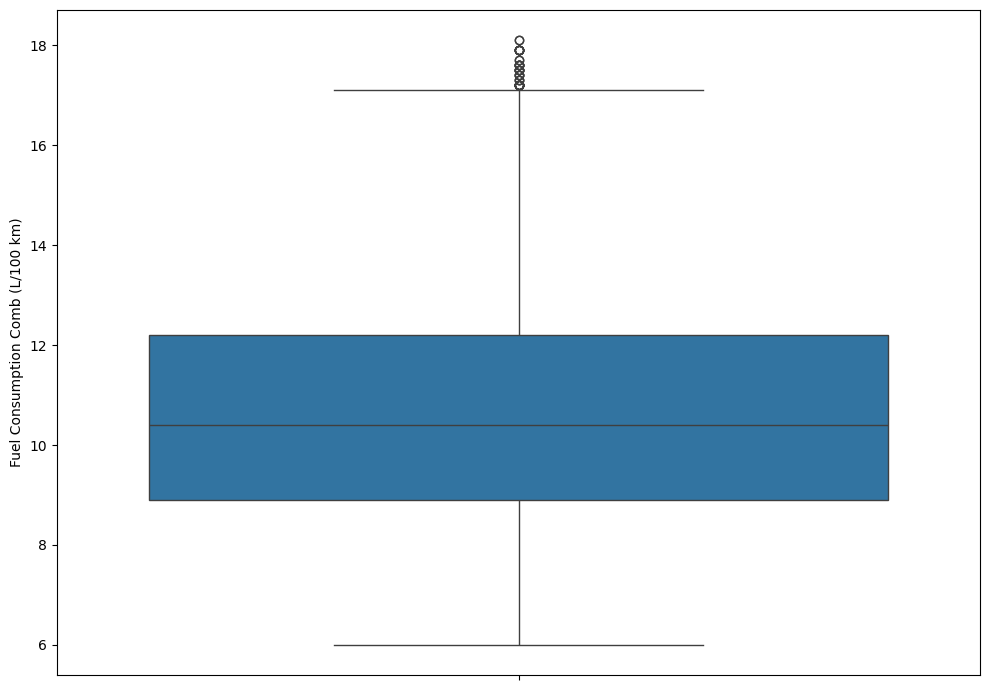

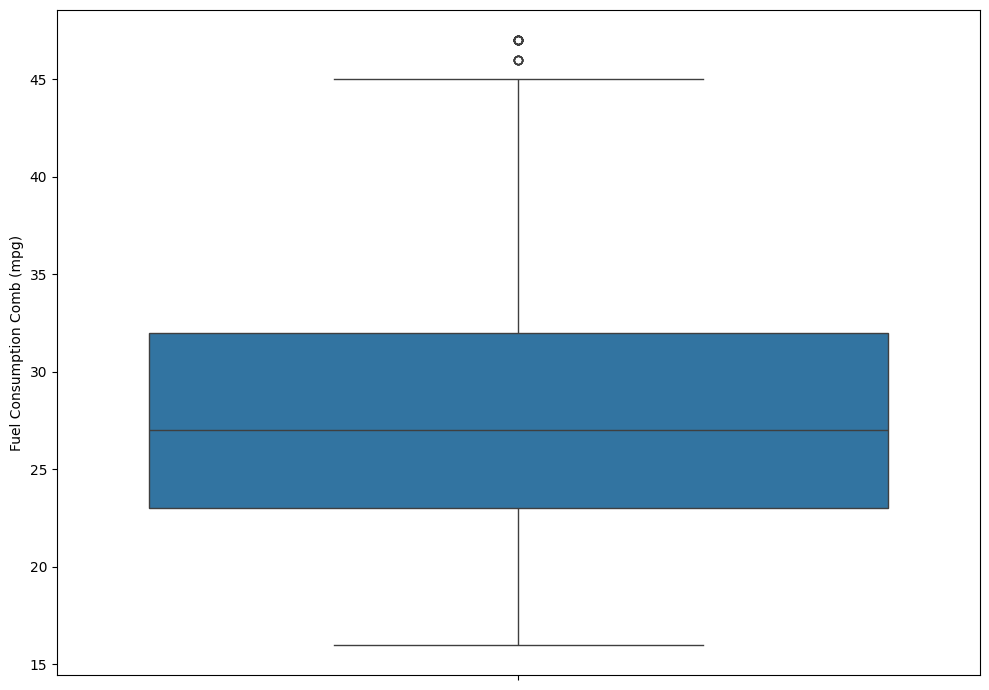

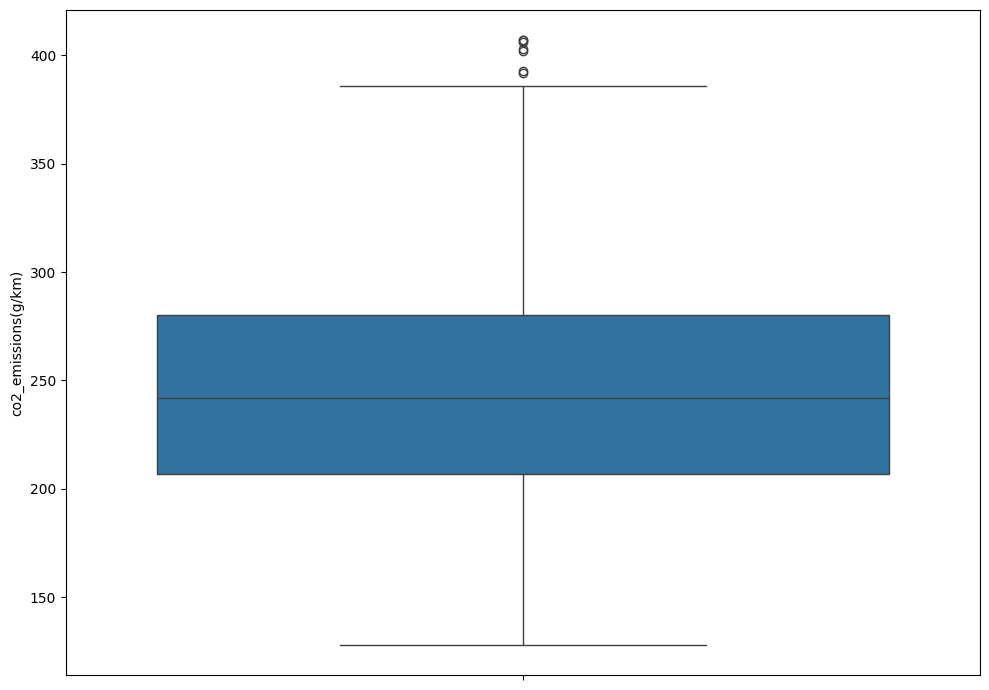

In [18]:
for i in transport_df_quantitative.columns:
    plt.figure(figsize=(10,7))
    sns.boxplot(data=filtered_transport_df, y=i)
    plt.tight_layout()

In [19]:
filtered_transport_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6826 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   make                              6826 non-null   object 
 1   model                             6826 non-null   object 
 2   vehicle_class                     6826 non-null   object 
 3   engine_size                       6826 non-null   float64
 4   cylinders                         6826 non-null   int64  
 5   transmission                      6826 non-null   object 
 6   fuel_type                         6826 non-null   object 
 7   Fuel Consumption City (L/100 km)  6826 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   6826 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  6826 non-null   float64
 10  Fuel Consumption Comb (mpg)       6826 non-null   int64  
 11  co2_emissions(g/km)               6826 non-null   int64  
dtypes: float64(